# Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pathlib as path
import copy
# Check PyTorch version
torch.__version__

'2.0.1+cu117'

# Data Read-in
Presumes that STEMVisualsSynthData.csv is in your working directory.
- data is read in, unneeded columns dropped
- Y holds concentration data one timestep ahead of X

In [4]:
rawData = pd.read_csv('STEMVisualsSynthData.csv', header=0)
#remove unneeded column
rawData.drop('Index_within_Experiment', axis = 1, inplace = True)
#X is inputs--the three Concentrations, F_in, I0 (light intensity), and c_N_in (6)
X = rawData[['Time', 'C_X', 'C_N', 'C_L', 'F_in', 'C_N_in', 'I0']]
Y = X.copy(deep=True)
#drop unnecessary rows in Y
Y.drop('F_in', axis = 1, inplace = True)
Y.drop('C_N_in', axis = 1, inplace = True)
Y.drop('I0', axis = 1, inplace = True)
Y.drop('Time', axis=1, inplace=True)
#Y vals should be X concentrations one timestep ahead, so remove the first index
Y.drop(index=0, inplace=True)
#To keep the two consistent, remove the last index of X
X.drop(index=19999, inplace=True)


C:\Users\kenda\AppData\Local\Temp\ipykernel_32680\4072410624.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.drop(index=19999, inplace=True)


# Data Split, Tensor Creation

In [5]:
#create training/validate/testing splits
train_ratio = 0.60
validation_ratio = 0.10
test_ratio = 0.20

# train is now 75% of the entire data set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=1 - train_ratio)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

#put our data into tensors
X_train = torch.tensor(X_train.values, dtype=torch.float32)
y_train = torch.tensor(Y_train.values, dtype=torch.float32)
X_test = torch.tensor(X_test.values, dtype=torch.float32)
y_test = torch.tensor(Y_test.values, dtype=torch.float32)
Xcopy = torch.tensor(X.values, dtype = torch.float32)
#print(x_train, x_val, x_test)

# Model
- first iteration is a shallow feedforward NN
- linear layers, start w/6 inputs, expand outward then converge
- 3 output lines
- activation between each linear
- current loss function is mean-squared, current optimizer is Adam with a learning rate of 0.0005

In [6]:
model = nn.Sequential(
    nn.Linear(7, 50),
    nn.LeakyReLU(),
    nn.Linear(50, 25),
    nn.LeakyReLU(),
    nn.Linear(25, 12),
    nn.LeakyReLU(),
    nn.Linear(12, 3)
)
#loss/optimizer
loss_fn = nn.MSELoss() #Mean Squared Error
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Training
Change num of epochs and batch size at the top.
- May take a while to run, dependent on your device.
- this mockup only uses a system CPU, we could make it device-agnostic later
- training set has 12,000 datapoints, if that helps to choose epochs/batch size

In [7]:
# training parameters
n_epochs = 100   # number of epochs to run
batch_size = 500  # size of each batch
batch_start = torch.arange(0, len(X_train), batch_size)
 
# Hold the best model
best_mse = np.inf   # init to infinity
best_weights = None
history = []
 
# training loop
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
        bar.set_description(f"Epoch {epoch}")
        for start in bar:
            # take a batch
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # print progress
            bar.set_postfix(mse=float(loss))
    # evaluate accuracy at end of each epoch
    model.eval()
    y_pred = model(X_test)
    mse = loss_fn(y_pred, y_test)
    mse = float(mse)
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
 
# restore model and return best accuracy
model.load_state_dict(best_weights)

<All keys matched successfully>

# Loss Graph
Loads in the best weights found during training, graphing the loss (both MSE and RMSE) over time. 

MSE: 0.40
RMSE: 0.63


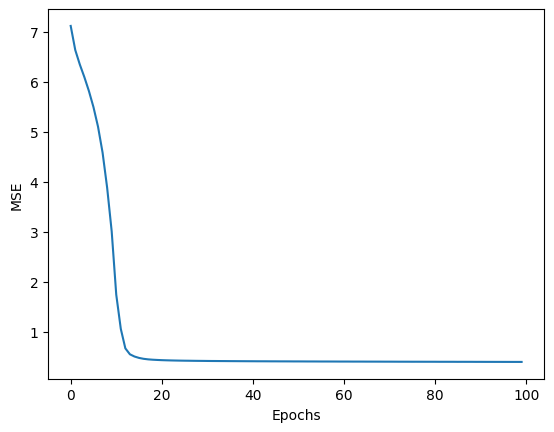

In [8]:
# restore model and return best accuracy
model.load_state_dict(best_weights)
print("MSE: %.2f" % best_mse)
print("RMSE: %.2f" % np.sqrt(best_mse))
plt.plot(history)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

# Rudimentary Visualization
- don't change what data the X values reference, as the 0th column represents Time
- to see the different concentrations, change the column Y 
    - C_X is 0
    - C_N is 1
    - C_L is 2

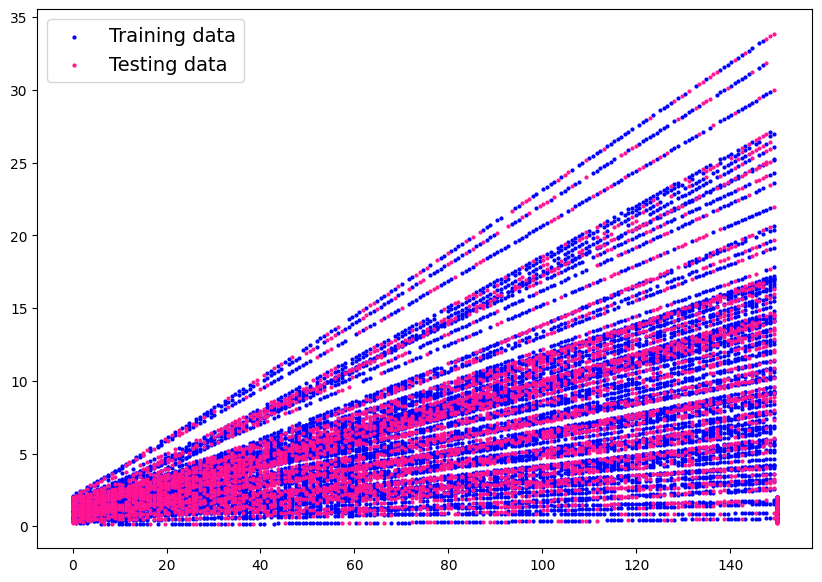

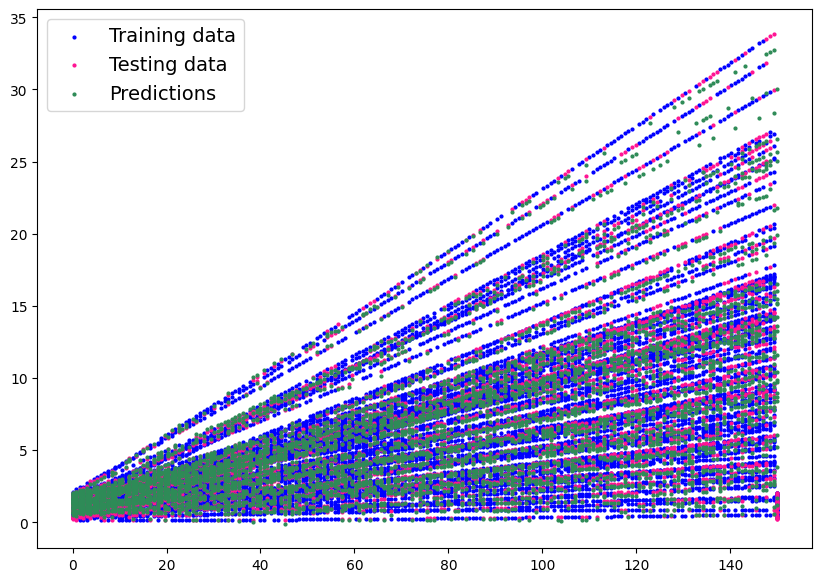

In [10]:
#quick visual just to see our data
def plot_predictions(train_data=X_train[:, 0], 
                     train_labels=y_train[:, 1], 
                     test_data=X_test[:, 0], 
                     test_labels=y_test[:, 1], 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7)) #create the base of our figure, figsize feeds in width/height in inches

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data") #c for color, s for size. 
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="deeppink", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="seagreen", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions();
# 1. Set the model in evaluation mode
model.eval()

# 2. Setup the inference mode context manager
with torch.inference_mode():
  # 3. Make sure the calculations are done with the model and data on the same device
  y_preds = model(X_test)
y_preds 
plot_predictions(predictions= torch.Tensor.cpu(y_preds[:, 1])) # gotta make sure that the model is on the cpu for this to work--this'll do nothing if already on cpu
